<a href="https://colab.research.google.com/github/Parul664/MRI_Classification/blob/master/Classificaiton_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
**Brain Tumor** is a mass or growth of abnormal cells in the brain. There are various kinds of tumors amongst which following are the most common types of tumors are 

*   Meningioma,
*   Glioma
*   Pituatary tumour.

Here is a brief info about the following tumors.


*   **Meningioma**
     A meningioma is a tumor that arises from the membranes that surround your brain and spinal cord.
*   **Glioma** 
     These tumors begin in the brain or spinal cord.
*   **Pituatary** 
     These are mostly benign tumors that develop in the pituitary gland at the base of the brain.



Early detection and correct identification of these tumors can be a life savior. \\
Hence, this notebook aims to develop a classification model that could accurately distinguish between these 3 types of tumors.

# Importing the required libraries






In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img,img_to_array
from google.colab import drive
import numpy as np
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
drive.mount('/content/drive')
!ls

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


# Dataset
The dataset has been taken from [figshare](https://figshare.com/articles/brain_tumor_dataset/1512427). It consists of 3064 T1-weighted contrast enhances images from 233 patients with 


*   meningioma tumor (708 slices)
*   glioma tumor (1426 slices)
*   pituitary tumor (930 slices)

The dataset is stored in .mat files in the form of a main dictionary with key as **cjdata** and another dictionary inside with keys as **label**, **PID**   (patient ID), **tumorMask**, **tumorBorder** and **image**.

# Extracting the dataset from .mat files

Import some more libraries and spliting the images on the basis of labels assigned to them and storing them in three folders id1, id2, id3 existing inside the working directory.

In [ ]:
import pandas as pd
import h5py
import random
import skimage.io as io
import matplotlib.image
%matplotlib inline


# This function was run on my local computer to segregate the data on the basis of labels. The images in each folder
# are assigned numers from 1 to n.
def prepare_dataset(main_dir,img_folder1,img_folder2,img_folder3):
    dataset_dict = {}
    labels = ['PID','image','label','tumorMask']
    for label in labels:
        dataset_dict[label] =[]
    index1 = 1
    index2 = 1
    index3 = 1
    for file_name in os.listdir(main_dir):
        full_loc = os.path.join(main_dir,file_name)
        print("Exploring file: ",full_loc)
        eg = {}
        f = h5py.File(full_loc,'r')
        content = f['cjdata']
        for k,v in content.items():
            eg[k] = np.asarray(v)
            
        eg['image'] = np.transpose(eg['image'])
        eg['label'] = eg['label'][0][0]
        if(eg['label']==1.):
            matplotlib.image.imsave(img_folder1+str(index1)+".jpg",eg['image'])
            im = Image.open(img_folder1+str(index1)+".jpg").convert('RGB').convert('L')
            if(np.shape(im)!=(512,512)):
                continue
            im.save(img_folder1+str(index1)+".jpg")
            print("id1", index1)
            index1 +=1
        if(eg['label']==2.):
            matplotlib.image.imsave(img_folder2+str(index2)+".jpg",eg['image'])
            im = Image.open(img_folder2+str(index2)+".jpg").convert('RGB').convert('L')
            if(np.shape(im)!=(512,512)):
                continue
            im.save(img_folder2+str(index2)+".jpg")
            print("id2", index2)
            index2 +=1
        if(eg['label']==3.):
            matplotlib.image.imsave(img_folder3+str(index3)+".jpg",eg['image'])
            im = Image.open(img_folder3+str(index3)+".jpg").convert('RGB').convert('L')
            if(np.shape(im)!=(512,512)):
                continue
            im.save(img_folder3+str(index3)+".jpg")
            print("id3", index3)
            index3 +=1
        f.close()
        

In [ ]:
#These commands were run on my local computer
main_dir = 'D:/BrainTumorDataset/Data_set_mat_files'
img_folder1 = 'D:/BrainTumorDataset/classification/id1/'
img_folder2 = 'D:/BrainTumorDataset/classification/id2/'
img_folder3 = 'D:/BrainTumorDataset/classification/id3/'
prepare_dataset(main_dir,img_folder1,img_folder2,img_folder3)

# Train-Test Split
This function divides the dataset randomly into 6 folders:


*   Train (id-1)
*   Train (id-2)
*   Train (id-3)
*   Test (id-1)
*   Test (id-2)
*   Test (id-3)

This function also removes the images if it is not of the required dimensions i.e. (512\*512) in my case.



In [ ]:
#This function was also run on my local computer
def get_train_test(folder1,folder2,folder3,train1,train2,train3,test1,test2,test3,train_test_ratio = 0.8):
    n1 = len(os.listdir(folder1))
    n2 = len(os.listdir(folder2))
    n3 = len(os.listdir(folder3))
    train_n1_no = int(train_test_ratio*n1)
    train_n2_no = int(train_test_ratio*n2)
    train_n3_no = int(train_test_ratio*n3)

    train_n1 = random.sample(range(1,n1+1),train_n1_no)
    train_n2 = random.sample(range(1,n2+1),train_n2_no)
    train_n3 = random.sample(range(1,n3+1),train_n3_no)
    test_n1 = [i for i in range(1,n1+1) if i not in train_n1]
    test_n2 = [i for i in range(1,n2+1) if i not in train_n2]
    test_n3 = [i for i in range(1,n3+1) if i not in train_n3]
    
    for file_no in train_n1:
        im = Image.open(folder1+str(file_no)+".jpg").convert('RGB').convert('L')
        if(np.shape(im)!=(512,512)):
            continue
        im.save(train1+str(file_no)+".jpg")
    for file_no in train_n2:
        im = Image.open(folder2+str(file_no)+".jpg").convert('RGB').convert('L')
        if(np.shape(im)!=(512,512)):
            continue
        im.save(train2+str(file_no)+".jpg")
    for file_no in train_n3:
        im = Image.open(folder3+str(file_no)+".jpg").convert('RGB').convert('L')
        if(np.shape(im)!=(512,512)):
            continue
        im.save(train3+str(file_no)+".jpg")
    for file_no in test_n1:
        im = Image.open(folder1+str(file_no)+".jpg").convert('RGB').convert('L')
        if(np.shape(im)!=(512,512)):
            continue
        im.save(test1+str(file_no)+".jpg")
    for file_no in test_n2:
        im = Image.open(folder2+str(file_no)+".jpg").convert('RGB').convert('L')
        if(np.shape(im)!=(512,512)):
            continue
        im.save(test2+str(file_no)+".jpg")
    for file_no in test_n3:
        im = Image.open(folder3+str(file_no)+".jpg").convert('RGB').convert('L')
        if(np.shape(im)!=(512,512)):
            continue
        im.save(test3+str(file_no)+".jpg")

In [ ]:
#These commands were run on my local computer
folder1 = 'D:/BrainTumorDataset/classification/id1/'
folder2 = 'D:/BrainTumorDataset/classification/id2/'
folder3 = 'D:/BrainTumorDataset/classification/id3/'
train1 = 'D:/BrainTumorDataset/classification/train1/'
train2 = 'D:/BrainTumorDataset/classification/train2/'
train3 = 'D:/BrainTumorDataset/classification/train3/'
test1 = 'D:/BrainTumorDataset/classification/test1/'
test2 = 'D:/BrainTumorDataset/classification/test2/'
test3 = 'D:/BrainTumorDataset/classification/test3/'
get_train_test(folder1,folder2,folder3,train1,train2,train3,test1,test2,test3)

The dataset created was then loaded into the drive in the format such that it can be used by the image Datagenerator and flow from Directory Functions.

# Checking if the Dataset is acessible and loaded correctly

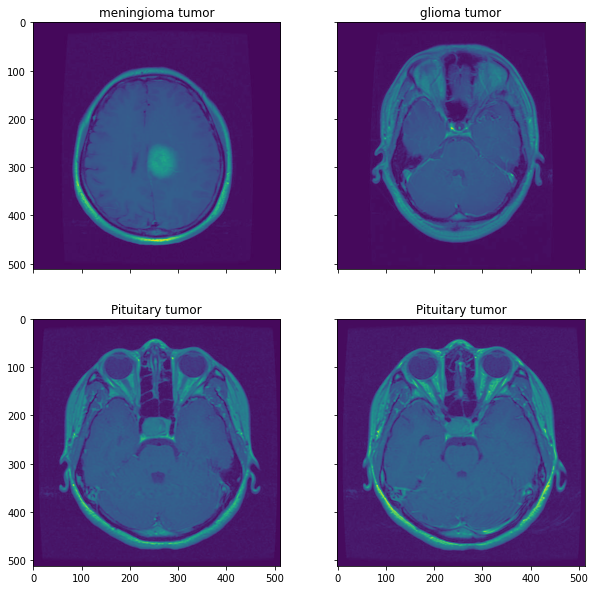

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))


image = load_img('/content/drive/My Drive/classification/test/test1/2.jpg', target_size=(512, 512))
img = img_to_array(image)
img = preprocess_input(img)
axs[0,0].imshow(img[:,:,2])
axs[0,0].set_title('meningioma tumor')
image = load_img('/content/drive/My Drive/classification/test/test2/1.jpg', target_size=(512, 512))
img = img_to_array(image)
img = preprocess_input(img)
axs[0,1].imshow(img[:,:,2])
axs[0,1].set_title('glioma tumor')
image = load_img('/content/drive/My Drive/classification/test/test3/1.jpg', target_size=(512, 512))
img = img_to_array(image)
img = preprocess_input(img)
axs[1,0].imshow(img[:,:,2])
axs[1,0].set_title('Pituitary tumor')
image = load_img('/content/drive/My Drive/classification/test/test3/2.jpg', target_size=(512, 512))
img = img_to_array(image)
img = preprocess_input(img)
axs[1,1].imshow(img[:,:,2])
axs[1,1].set_title('Pituitary tumor')
for ax in axs.flat:
    ax.label_outer()


# Making the Model
The model was made using transfer learning from VGG16 model with some top layers re-trained. Softmax was used as the top layer.

In [ ]:
def model():

  input_tensor = Input(shape=(512,512,3))
  base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

  top_model = Sequential()
  top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  top_model.add(Dense(256, activation='relu'))
  top_model.add(Dropout(0.5))
  top_model.add(Dense(3, activation='softmax'))

  # add the model on top of the convolutional base
  model = Model(input= base_model.input, output= top_model(base_model.output))
  #for layer in model.layers:
  #  print(layer)
  model.get_layer('block1_conv1').trainable = False
  model.get_layer('block1_conv2').trainable = False
  model.get_layer('block2_conv1').trainable = False
  model.get_layer('block2_conv2').trainable = False
  model.get_layer('block3_conv1').trainable = False
  model.get_layer('block3_conv2').trainable = False
  model.get_layer('block3_conv3').trainable = False
  model.get_layer('block2_conv2').trainable = False
  model.get_layer('block4_conv1').trainable = False
  model.get_layer('block4_conv2').trainable = False
  model.get_layer('block4_conv3').trainable = False

  model.compile( optimizer = Adam(lr=1e-7), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  return model


In [ ]:
model = model()

58892288/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
____________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  del sys.path[0]


# Visualising the model's input output

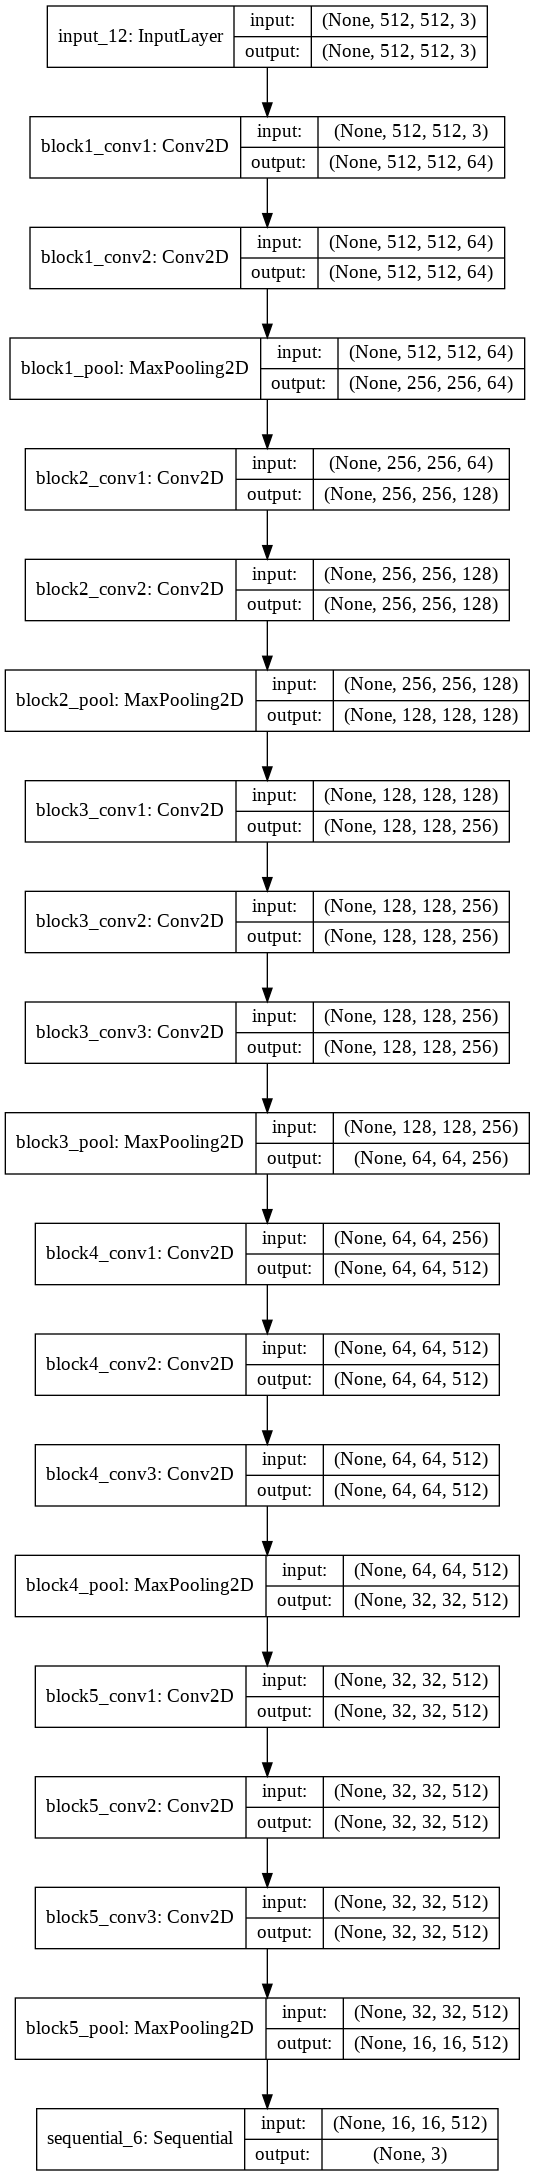

In [ ]:

import keras
keras.utils.plot_model(model, show_shapes=True)

# Creating Datagenerator for both train and test images

In [ ]:

seed = 9
batch_size = 2
train_dir = '/content/drive/My Drive/classification/train/'
test_dir = '/content/drive/My Drive/classification/test/'

train_datagen = ImageDataGenerator(rescale=1./255)
#validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (512,512),
                                                    batch_size = batch_size,
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    seed = seed,
                                                    shuffle = True)
test_generator = train_datagen.flow_from_directory(test_dir,
                                                    target_size = (512,512),
                                                    batch_size = batch_size,
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                   seed = seed)

Found 2438 images belonging to 3 classes.
Found 611 images belonging to 3 classes.


In [ ]:
# For Debugging purposes
x_batch, y_batch = next(train_generator)
np.shape(x_batch)

(1, 512, 512, 3)

#Training the model
The model was trained for a total of 30 epoches in parts of 20 and 10 st the end of which it attains an accuracy of about 90% on the test Datset.

In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs = 20,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples//test_generator.batch_size
                    )

Epoch 1/20
1219/1219 [==============================] - 493s 405ms/step - loss: 1.0817 - accuracy: 0.4647 - val_loss: 0.8039 - val_accuracy: 0.6689
Epoch 2/20
1219/1219 [==============================] - 334s 274ms/step - loss: 0.9093 - accuracy: 0.5792 - val_loss: 0.3610 - val_accuracy: 0.6929
Epoch 3/20
1219/1219 [==============================] - 333s 273ms/step - loss: 0.7953 - accuracy: 0.6481 - val_loss: 0.5485 - val_accuracy: 0.7225
Epoch 4/20
1219/1219 [==============================] - 333s 273ms/step - loss: 0.7138 - accuracy: 0.6879 - val_loss: 0.5629 - val_accuracy: 0.7225
Epoch 5/20
1219/1219 [==============================] - 334s 274ms/step - loss: 0.6622 - accuracy: 0.7022 - val_loss: 0.4667 - val_accuracy: 0.7356
Epoch 6/20
1219/1219 [==============================] - 333s 273ms/step - loss: 0.6210 - accuracy: 0.7301 - val_loss: 0.5658 - val_accuracy: 0.7668
Epoch 7/20
1219/1219 [==============================] - 333s 273ms/step - loss: 0.5928 - accuracy: 0.7441 - val_

In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs = 10,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples//test_generator.batch_size
                    )

Epoch 1/10
1219/1219 [==============================] - 332s 272ms/step - loss: 0.3479 - accuracy: 0.8610 - val_loss: 0.0572 - val_accuracy: 0.8721
Epoch 2/10
1219/1219 [==============================] - 330s 271ms/step - loss: 0.3400 - accuracy: 0.8675 - val_loss: 0.2329 - val_accuracy: 0.8801
Epoch 3/10
1219/1219 [==============================] - 332s 273ms/step - loss: 0.3355 - accuracy: 0.8696 - val_loss: 0.3328 - val_accuracy: 0.8506
Epoch 4/10
1219/1219 [==============================] - 336s 275ms/step - loss: 0.3176 - accuracy: 0.8733 - val_loss: 0.1820 - val_accuracy: 0.8703
Epoch 5/10
1219/1219 [==============================] - 332s 272ms/step - loss: 0.3099 - accuracy: 0.8815 - val_loss: 0.1930 - val_accuracy: 0.8736
Epoch 6/10
1219/1219 [==============================] - 332s 273ms/step - loss: 0.3029 - accuracy: 0.8893 - val_loss: 1.3652 - val_accuracy: 0.8834
Epoch 7/10
1219/1219 [==============================] - 333s 273ms/step - loss: 0.2867 - accuracy: 0.8970 - val_

In [ ]:
from keras import backend as K    
K.set_image_data_format('channels_last')

# Saving the Model


In [ ]:
model.save("/content/drive/My Drive/classification_trial1")

Saving the model in .h5 format also, required for making the webapp.

In [ ]:
new_model.save("/content/drive/My Drive/classification_trial1__hdf5.h5")

# Plotting the Accuracy and Loss Metrics of the train and the test set

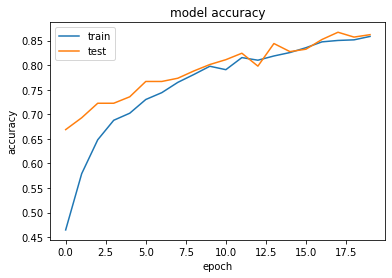

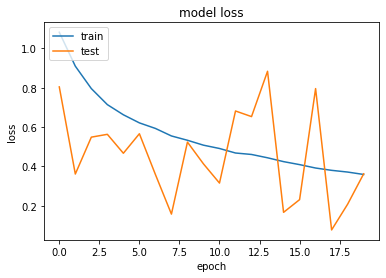

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Loading the model for evaluating the results

In [ ]:
from keras import models
new_model = models.load_model("/content/drive/My Drive/classification_trial1__hdf5.h5")

# Visualising the Results
Taking the first 10 images in the Test set and printing their predictions along with the true labels

In [ ]:
def prepare_test_dataset2(train_dir_img, true_label):
    count = 0
    for file_name in os.listdir(train_dir_img):
        a = []
        full_loc = os.path.join(train_dir_img,file_name)
        print("Image " ,file_name)
        img = Image.open(full_loc)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
        plt.imshow(img[:,:,0])
        plt.show()
        img = np.repeat(img, 3, 2)
        a.append(img)
        #Labels lie between 0 to 2, so adding 1 to change the range from 1 to 3
        print('Predicted Label: ',1+np.argmax(new_model.predict(np.asarray(a))),"True Label", true_label)
        print()
        count+=1
        if(count>10):
          return
        
    
    
        

Image  1.jpg


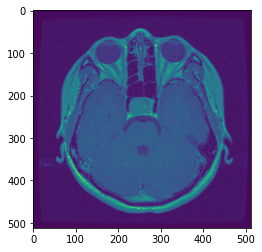

Predicted Label:  3 True Label 3

Image  46.jpg


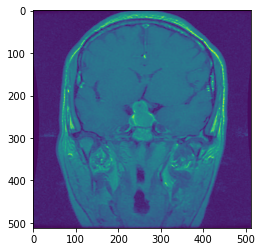

Predicted Label:  3 True Label 3

Image  12.jpg


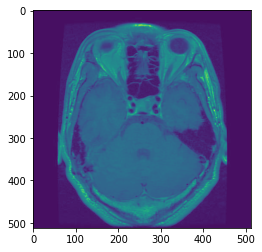

Predicted Label:  3 True Label 3

Image  26.jpg


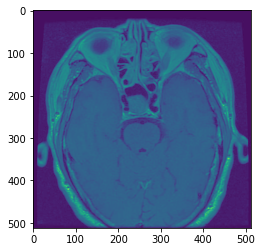

Predicted Label:  3 True Label 3

Image  5.jpg


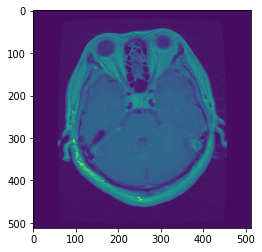

Predicted Label:  3 True Label 3

Image  44.jpg


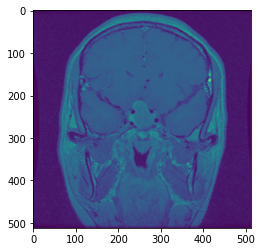

Predicted Label:  3 True Label 3

Image  6.jpg


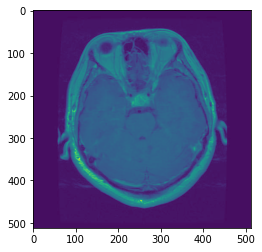

Predicted Label:  3 True Label 3

Image  14.jpg


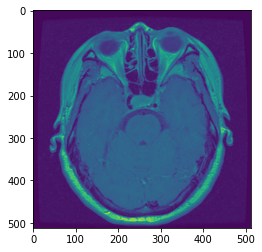

Predicted Label:  3 True Label 3

Image  2.jpg


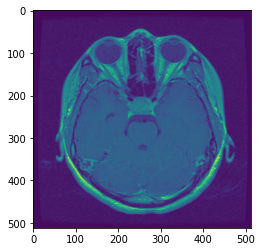

Predicted Label:  3 True Label 3

Image  51.jpg


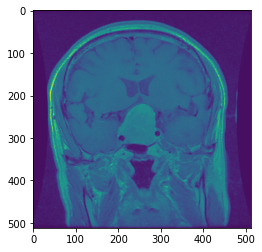

Predicted Label:  3 True Label 3

Image  24.jpg


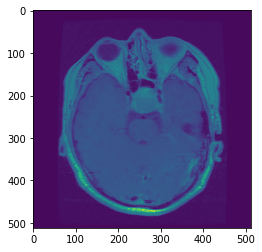

Predicted Label:  3 True Label 3



In [ ]:
train_dir_img='/content/drive/My Drive/classification/test/test3'
prepare_test_dataset2(train_dir_img,3)


Image  1.jpg


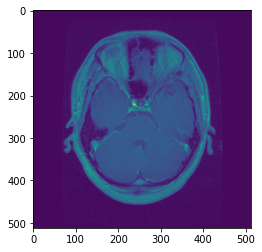

Predicted Label:  2 True Label 2

Image  256.jpg


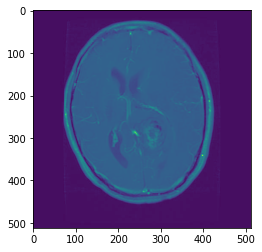

Predicted Label:  2 True Label 2

Image  280.jpg


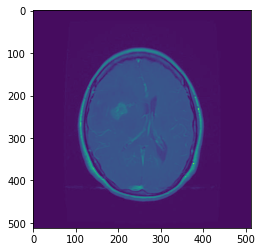

Predicted Label:  2 True Label 2

Image  297.jpg


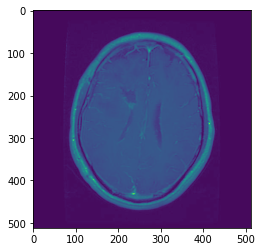

Predicted Label:  2 True Label 2

Image  39.jpg


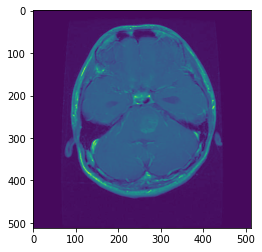

Predicted Label:  2 True Label 2

Image  233.jpg


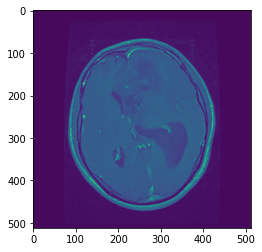

Predicted Label:  2 True Label 2

Image  47.jpg


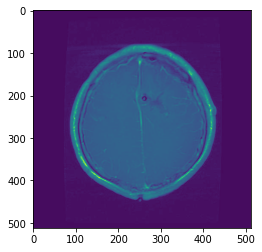

Predicted Label:  2 True Label 2

Image  257.jpg


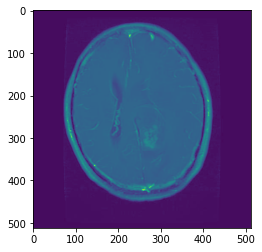

Predicted Label:  2 True Label 2

Image  230.jpg


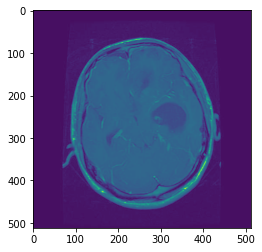

Predicted Label:  2 True Label 2

Image  209.jpg


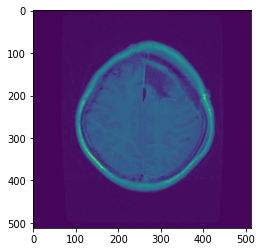

Predicted Label:  2 True Label 2

Image  229.jpg


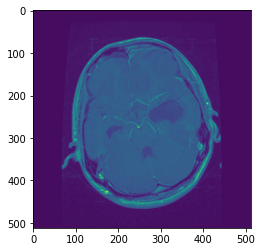

Predicted Label:  2 True Label 2



In [ ]:
train_dir_img='/content/drive/My Drive/classification/test/test2'
prepare_test_dataset2(train_dir_img,2)

Image  175.jpg


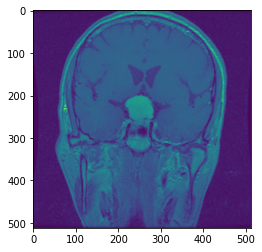

Predicted Label:  3 True Label 1

Image  199.jpg


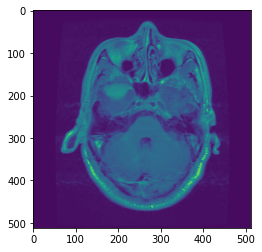

Predicted Label:  1 True Label 1

Image  331.jpg


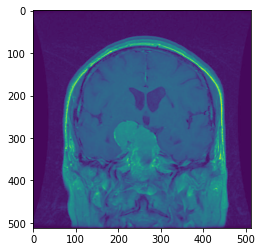

Predicted Label:  1 True Label 1

Image  4.jpg


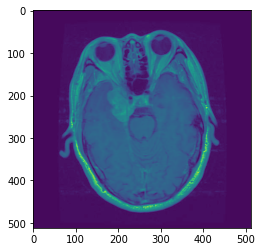

Predicted Label:  3 True Label 1

Image  157.jpg


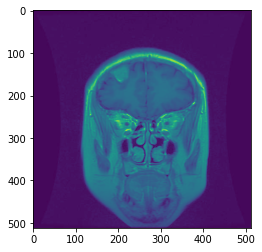

Predicted Label:  1 True Label 1

Image  416.jpg


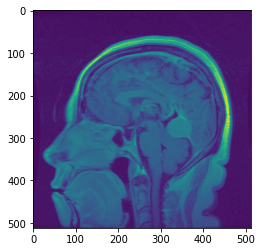

Predicted Label:  1 True Label 1

Image  276.jpg


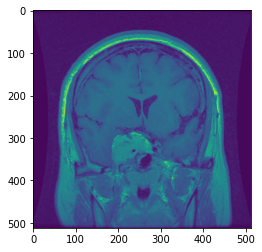

Predicted Label:  3 True Label 1

Image  337.jpg


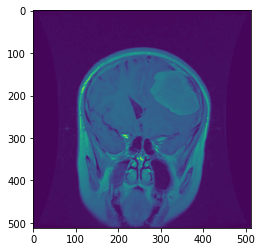

Predicted Label:  2 True Label 1

Image  404.jpg


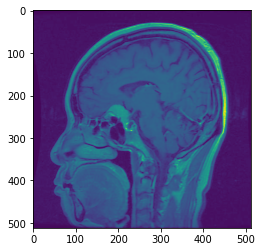

Predicted Label:  1 True Label 1

Image  160.jpg


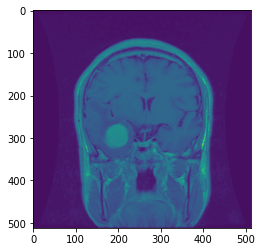

Predicted Label:  1 True Label 1

Image  417.jpg


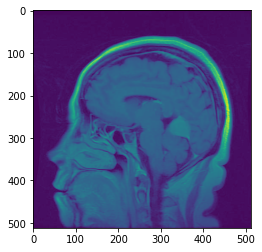

Predicted Label:  1 True Label 1



In [ ]:
train_dir_img='/content/drive/My Drive/classification/test/test1'
prepare_test_dataset2(train_dir_img,1)

# Counting predictions of each category in Test Data of a particular Brain Tumor label

In [ ]:
def prepare_test_dataset(train_dir_img):
    test_x = []
    for file_name in os.listdir(train_dir_img):
        full_loc = os.path.join(train_dir_img,file_name)
        #print(file_name)
        img = Image.open(full_loc)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
        img = np.repeat(img, 3, 2)
        test_x.append(img)
        
        
    test_x = np.asarray(test_x)
    return test_x
        

In [ ]:
train_dir_img='/content/drive/My Drive/classification/test/test2'
x = prepare_test_dataset(train_dir_img)
y_pred = new_model.predict(x)

In [ ]:
c_1,c_2,c_3 = 0,0,0
for i,j,k in y_pred:
  if (i>j and i>k):
    c_1+=1
  elif (j>i and j>k):
    c_2+=1
  else :
    c_3+=1
print(c_1,c_2,c_3)

13 266 7


In [ ]:

train_dir_img='/content/drive/My Drive/classification/test/test3'
x = prepare_test_dataset(train_dir_img)
y_pred = new_model.predict(x)

In [ ]:
c_1,c_2,c_3 = 0,0,0
for i,j,k in y_pred:
  if (i>j and i>k):
    c_1+=1
  elif (j>i and j>k):
    c_2+=1
  else :
    c_3+=1
print(c_1,c_2,c_3)

0 3 180


In [ ]:

train_dir_img='/content/drive/My Drive/classification/test/test1'
x = prepare_test_dataset(train_dir_img)
y_pred = new_model.predict(x)

In [ ]:
c_1,c_2,c_3 = 0,0,0
for i,j,k in y_pred:
  if (i>j and i>k):
    c_1+=1
  elif (j>i and j>k):
    c_2+=1
  else :
    c_3+=1
print(c_1,c_2,c_3)

73 60 9
